## Independent Coding Project for York University's Certificate in ML, Course 2

### prepared by Robin Mathew on 22-Jan-2021

## Word2Vec Embedding model training and evaluation

Let's start with importing the libraries

In [1]:
import pandas as pd
import numpy as np
import os
import json
import sqlite3
import pickle
import gc
from bs4 import BeautifulSoup
from nltk.corpus import stopwords
import unicodedata
import re
#from pycontractions import Contractions
#cont = Contractions('GoogleNews-vectors-negative300.bin') #uses word2vec semantic vector model pre-trained on 
#       GoogleNews dataset
#cont.load_models() # loads and keeps in memory to avoid runtime call
import spacy
nlp = spacy.load("en_core_web_sm")
pd.set_option('display.max_columns',15)
import tldextract
import category_encoders as ce
from collections import OrderedDict
import scipy

import seaborn as sns
import matplotlib.pyplot as plt

from sklearn import preprocessing
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import TfidfTransformer

from sklearn.manifold import TSNE

import nltk.data
tokenizer = nltk.data.load('tokenizers/punkt/english.pickle')
wpt = nltk.WordPunctTokenizer()

import gensim, logging
logging.basicConfig(format='%(asctime)s : %(levelname)s : %(message)s', level=logging.INFO)
#from multiprocessing import cpu_count

## The dataset for this project is the fake news data, available in json files. I have already pickled the data in a cleaned dataframe which we will directly import. Below is the code to read, pre-process and normalise the data.

In [ ]:
df_data = []  
for curr_path,sub_folder_list,file_list in os.walk("C:\\Users\\mrrob\\Desktop\\Machine Learning York University\\Course 2\\NLP Project\\fakenewsnet_dataset\\fakenewsnet_dataset\\gossipcop\\fake"):
    for curr_file in file_list:
        with open(curr_path+'\\'+curr_file) as f:
            data = json.load(f) 
            vsite_name=data.get("meta_data",{}).get("og",{}).get("site_name","")
            vtype=data.get("meta_data",{}).get("og",{}).get("type","")
            vtitle=data.get("meta_data",{}).get("og",{}).get("title","")
            vurl=data.get("url","")
            vtext=data.get("text","")
            vauthors=data["authors"]
            vfake=True
            df_data.append([vsite_name,vtype,vtitle,vurl,vtext,vauthors,vfake])  
df_fake=pd.DataFrame(data=df_data, columns=['site_name','type','title', 'url','text','authors','fake']) 

df_data = []
for curr_path,sub_folder_list,file_list in os.walk("C:\\Users\\mrrob\\Desktop\\Machine Learning York University\\Course 2\\NLP Project\\fakenewsnet_dataset\\fakenewsnet_dataset\\gossipcop\\real"):
    for curr_file in file_list:
        with open(curr_path+'\\'+curr_file) as f:
            data = json.load(f)
            vsite_name=data.get("meta_data",{}).get("og",{}).get("site_name","")
            vtype=data.get("meta_data",{}).get("og",{}).get("type","")
            vtitle=data.get("meta_data",{}).get("og",{}).get("title","")
            vurl=data.get("url","")
            vtext=data.get("text","")
            vauthors=data["authors"]
            vfake=False
            df_data.append([vsite_name,vtype,vtitle,vurl,vtext,vauthors,vfake])
df_real=pd.DataFrame(data=df_data, columns=['site_name','type','title','url','text','authors','fake'])

df = pd.concat([df_fake,df_real])

# remove documents with blank text
df=df[df['text']!=""]
df.drop_duplicates(subset=['text'], keep='last',inplace=True)
df["text_length"]=df["text"].apply(len)
df=df[(df['text_length']<5000) & (df['text_length']>150)]

df.reset_index(inplace=True) 
df.drop('index',axis=1,inplace=True)
df.reset_index(inplace=True) 

df['authors'] = df[df['authors'].apply(len)>0]['authors'].apply(lambda x: x[0])
# empty authors become overwritten with NaN

def get_site_name(url):
    s = url
    ext = tldextract.extract(s)
    result = (ext.subdomain+'.'+ext.domain +'.'+ext.suffix).strip('.')
    if result == 'web.archive.org':
        s = s.split('/', 5)[-1]
        ext = tldextract.extract(s)
    #result = (ext.subdomain + '.' + ext.domain + '.' + ext.suffix).strip('.')
    result = (ext.domain).strip('.')
    return result

df['site_name'] = df.apply(lambda x: get_site_name(x.url), axis=1) 
df.loc[df['authors'].isnull(),'authors'] = df[df['authors'].isnull()]['site_name'].apply(lambda x: x) 
df.loc[df['type']=='','type'] = df[df['type']=='']['type'].apply(lambda x: 'article') 

df.drop('url',axis=1,inplace=True)


In [ ]:
def text_normalizer(doc):

    soup = BeautifulSoup(doc, 'html.parser')
    normalized_doc = soup.get_text() #remove HTML tags
    normalized_doc = re.sub(r'[\r|\n|\r\n]+', ' ',normalized_doc) # remove extra newlines \r carriage return \n new line
    normalized_doc = unicodedata.normalize('NFKD', normalized_doc).encode('ascii', 'ignore').decode('utf-8', 'ignore') # strip accents
    normalized_doc = re.sub("[’]", '', normalized_doc) #nlp uses punctuation info so remove others last. this special character apostrophe prevents expansion, so removed.
    normalized_doc_list = normalized_doc.split()
    normalized_doc_list = [word for word in normalized_doc_list if word.lower() not in stopwords.words('english')] # remove stopwords before expansion
    normalized_doc = ' '.join(normalized_doc_list)
    normalized_doc_list = [normalized_doc]
    normalized_doc = list(cont.expand_texts(normalized_doc_list, precise=False))[0] # expansion
    normalized_doc_list = normalized_doc.split()
    normalized_doc_list = [word for word in normalized_doc_list if word.lower() not in stopwords.words('english')] # remove stopwords after expansion
    normalized_doc = ' '.join(normalized_doc_list)
    nlp_doc=nlp(normalized_doc) # nlp, lemmatization (base word) and capturing POS tags. 
    normalized_doc_list = [word.lemma_ if word.lemma_ != '-PRON-' else word.text for word in nlp_doc]
    spacy_proper_nouns = [word.lemma_.lower() for word in nlp_doc if word.pos_ == "PROPN"]
    spacy_verbs = [word.lemma_.lower() for word in nlp_doc if word.pos_ == "VERB"]
    spacy_adj = [word.lemma_.lower() for word in nlp_doc if word.pos_ == "ADJ"]
    spacy_ner = [entity.text.lower() for entity in nlp_doc.ents if entity.label_ in ['PERSON', 'NORP', 'ORG', 'EVENT', 'PRODUCT']]
    # insert spaces between special characters to isolate them
    special_char_pattern = re.compile(r'([\[\]{.(-)!}])')
    normalized_doc = ' '.join(normalized_doc_list)
    normalized_doc = special_char_pattern.sub(" \\1 ", normalized_doc)
    normalized_doc = re.sub("[^a-zA-Z0-9\s]", '', normalized_doc) #nlp uses punctuation info so removed last
    normalized_doc = re.sub(' +', ' ', normalized_doc) # extra white spaces removed
    normalized_doc = normalized_doc.lower() # lowercase after spacy for helping nouns standout
    normalized_doc_list = normalized_doc.split()

    return {'normal_text':normalized_doc_list, 'proper_nouns': spacy_proper_nouns, 'verbs':spacy_verbs, 'adj':spacy_adj, 'ner':spacy_ner}

A less constrained normalization for training word2vec's first layer since it carries a lot of contextual information. e.g the stopwords

In [6]:
def word2vec_normalizer(doc):

    soup = BeautifulSoup(doc, 'html.parser')
    normalized_doc = soup.get_text() #remove HTML tags
    normalized_doc = re.sub(r'[\r|\n|\r\n]+', ' ',normalized_doc) # remove extra newlines
    normalized_doc = unicodedata.normalize('NFKD', normalized_doc).encode('ascii', 'ignore').decode('utf-8', 'ignore') # strip accents
    # insert spaces between special characters to isolate them
    special_char_pattern = re.compile(r'([\[\]{.(-)!}])')
    normalized_doc = special_char_pattern.sub("\\1 ", normalized_doc)
    normalized_doc = normalized_doc.lower() # lowercase after spacy for helping nouns standout

    return normalized_doc

### For most projects with smaller datasets and less computational resources, it is worthwhile to pay attention to the pre-processing and normalization. For large scale datasets, employing complex deep learning techniques, mutations and other irregularities given the larger context may merge / cancel out eventually.

In [2]:
# I have saved the cleaned, pre-processed dataframe with normalised text in the pickle file for quick import.

pickle_file_final = open('pickle_file_final','rb')
pickled_objs=pickle.load(pickle_file_final)
df=pickled_objs[0]
embedded_df=pickled_objs[1]
pickle_file_final.close()


In [3]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 14968 entries, 0 to 14967
Data columns (total 19 columns):
 #   Column                Non-Null Count  Dtype 
---  ------                --------------  ----- 
 0   authors               14968 non-null  int16 
 1   fake                  14968 non-null  int32 
 2   site_name             14968 non-null  int16 
 3   text                  14968 non-null  object
 4   text_length           14968 non-null  int64 
 5   title                 14968 non-null  object
 6   type                  14968 non-null  int8  
 7   normal_text           14968 non-null  object
 8   proper_nouns          14968 non-null  object
 9   verbs                 14968 non-null  object
 10  adj                   14968 non-null  object
 11  ner                   14968 non-null  object
 12  normal_title          14968 non-null  object
 13  adverbs               14968 non-null  object
 14  word2vec_normal_text  14968 non-null  object
 15  sentence_list         14968 non-null

In [4]:
df['normal_text']

0        [star, magazine, release, explosive, report, t...
1        [early, year, buzz, around, megyn, kellys, mov...
2        [first, time, since, involvement, fatal, car, ...
3        [heel, cute, last, long, selena, gomez, wear, ...
4        [jessica, simpsons, beloved, dog, daisy, snatc...
                               ...                        
14963    [open, letter, cast, reference, change, org, p...
14964    [robert, pattinson, rumor, date, suki, waterho...
14965    [easy, pull, marvelous, second, time, around, ...
14966    [kesha, quite, year, third, album, rainbow, re...
14967    [meghan, markle, prince, harry, prove, intervi...
Name: normal_text, Length: 14968, dtype: object

### About training the embedding model using Gensim

gensim’s word2vec expects a sequence of sentences as its input.

e.g.

sentences = [['first', 'sentence'], ['second', 'sentence']]

model = gensim.models.Word2Vec(sentences, min_count=1)

###### Important note about resuming training of existing model: 

The learning decay rate is disturbed when the model stops and starts again. So unless you are an advanced user who knows how to set the new decay rate while starting (which is not a simple task), don't do it. It's like the model learns from scratch when started again unless decay parameter is adjusted. So try it in one go for simplicity.



### 1st layer - lightly normalised text articles

In [7]:
df['word2vec_normal_text'] = df['text'].apply(word2vec_normalizer) # one string

### tokenize into sentences from paragraphs
df['sentence_list'] = df['word2vec_normal_text'].apply(tokenizer.tokenize) # list of strings (sentences)

### remove invalid sentences
df['sentence_list'] = df['sentence_list'].apply(lambda sentence_list:[sent for sent in sentence_list if len(sent)>6])

### tokenize into words and remove words with length 1
df['sentence_list'] = df['sentence_list'].apply(lambda sentence_list:[wpt.tokenize(sent) for sent in sentence_list]) # list of words for each sentence
df['sentence_list'] = df['sentence_list'].apply(lambda sentence_list:[[word for word in sent if len(word)>1] for sent in sentence_list])

document_sentence_list = df['sentence_list'].tolist()

master_sentence_list = [] # initialise

for sent in document_sentence_list:
    for sub_sent in sent:
        master_sentence_list.append(sub_sent)


### 2nd layer - highly normalised text articles

In [8]:
df['normal_text'] = df['normal_text'].apply(lambda word_list:[word for word in word_list if len(word)>1])
document_sentence_list = df['normal_text'].tolist()
for sent in document_sentence_list:
    master_sentence_list.append(sent)

### 3rd layer - normalised title

In [9]:
df['normal_title'] = df['normal_title'].apply(lambda word_list:[word for word in word_list if len(word)>1])
document_sentence_list = df['normal_title'].tolist()
for sent in document_sentence_list:
    master_sentence_list.append(sent)

### 4th layer - normalised Nouns, Adverbs and Verbs only

In [10]:
def extract_nav(normal_text):
    nlp_doc = nlp(normal_text)
    spacy_nav = [word.lemma_.lower() for word in nlp_doc if word.pos_ in ["NOUN","PROPN","ADV","VERB"]]
    return spacy_nav
df["normal_nav"] = df['normal_text'].apply(' '.join).apply(extract_nav)
df['normal_nav'] = df['normal_nav'].apply(lambda word_list:[word for word in word_list if len(word)>1])
document_sentence_list = df['normal_nav'].tolist()
for sent in document_sentence_list:
    master_sentence_list.append(sent)

### 5th layer - normalised Nouns and Adjectives only

In [11]:
def extract_na(normal_text):
    nlp_doc = nlp(normal_text)
    spacy_na = [word.lemma_.lower() for word in nlp_doc if word.pos_ in ["NOUN","PROPN","ADJ"]]
    return spacy_na
df["normal_na"] = df['normal_text'].apply(' '.join).apply(extract_na)
df['normal_na'] = df['normal_na'].apply(lambda word_list:[word for word in word_list if len(word)>1])
document_sentence_list = df['normal_na'].tolist()
for sent in document_sentence_list:
    master_sentence_list.append(sent)


### 6th layer - Named Entities only

In [12]:
df['ner_split'] = df['ner'].apply(' '.join).apply(lambda word_list:[word for word in word_list.split() if len(word)>1])
document_sentence_list = df['ner_split'].tolist()
for sent in document_sentence_list:
    master_sentence_list.append(sent)


### Why so many layers?

The objective of this layers is to increase the breadth and depth of the contextual information that the model can train on. By providing the associations in different formats as seen in the above layers, the model gets a wide span of contextual information instead of just relying on complex deep learning techniques or large sliding windows requiring massive computational resources. So I am trying to feed greater contextual information in a much simpler and cheaper way.



### Let's train the model on Skip-Gram (Negative Sampling of 5) or C-BoW architecture

In [13]:
# train word2vec

#CBOW
#w2v_model = gensim.models.Word2Vec(master_sentence_list, min_count=6, size=100, workers=8, iter=50)

#SG - skip gram indicated by sg=1
#w2v_model = gensim.models.Word2Vec(master_sentence_list, sg=1, min_count=6, size=100, workers=8, iter=50)

#w2v_model.save('word2vecmodel')
#w2v_model.save('word2vecmodel_sg')


I could train a 50-epoch model in a few minutes for both the above methods.

### Let's explore the C-BoW model first

In [14]:
w2v_model = gensim.models.Word2Vec.load('word2vecmodel')

2021-01-22 01:38:38,165 : INFO : loading Word2Vec object from word2vecmodel
2021-01-22 01:38:38,479 : INFO : loading wv recursively from word2vecmodel.wv.* with mmap=None
2021-01-22 01:38:38,480 : INFO : setting ignored attribute vectors_norm to None
2021-01-22 01:38:38,481 : INFO : loading vocabulary recursively from word2vecmodel.vocabulary.* with mmap=None
2021-01-22 01:38:38,482 : INFO : loading trainables recursively from word2vecmodel.trainables.* with mmap=None
2021-01-22 01:38:38,483 : INFO : setting ignored attribute cum_table to None
2021-01-22 01:38:38,485 : INFO : loaded word2vecmodel


In [15]:
similar_words = {search_term: [item[0] for item in w2v_model.wv.most_similar([search_term], topn=5)]
                  for search_term in ['fake','actor','politician','kardashian']}
similar_words


2021-01-22 01:38:45,755 : INFO : precomputing L2-norms of word weight vectors


{'fake': ['false', 'fabricated', 'fabricate', 'fabricating', 'spread'],
 'actor': ['actress', 'star', 'singer', 'musician', 'comedian'],
 'politician': ['politicians', 'liberal', 'repeal', 'leader', 'government'],
 'kardashian': ['kardashians', 'kylie', 'kanye', 'kris', "kardashian's"]}

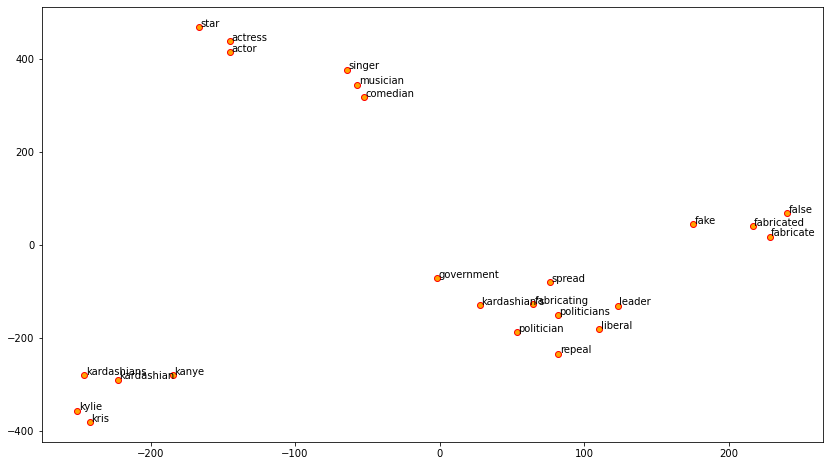

In [16]:
words = sum([[k] + v for k, v in similar_words.items()], [])
wvs = w2v_model.wv[words]

tsne = TSNE(n_components=2, random_state=0, n_iter=10000, perplexity=2)
np.set_printoptions(suppress=True)
T = tsne.fit_transform(wvs)
labels = words

plt.figure(figsize=(14, 8))
plt.scatter(T[:, 0], T[:, 1], c='orange', edgecolors='r')
for label, x, y in zip(labels, T[:, 0], T[:, 1]):
    plt.annotate(label, xy=(x+1, y+1), xytext=(0, 0), textcoords='offset points')

plt.show()

In [18]:
w2v_model.wv.most_similar(positive=['donald','trump','daughter'])

[('ivanka', 0.6434186697006226),
 ('balleralert', 0.602169930934906),
 ('trumps', 0.5941944122314453),
 ('ivankatrump', 0.5644876956939697),
 ("trump's", 0.5506808757781982),
 ('jeb', 0.5388776063919067),
 ('president', 0.5292946100234985),
 ('administrations', 0.5158790349960327),
 ('clinton', 0.5064904689788818),
 ('friese', 0.5061112642288208)]

In [19]:
w2v_model.wv.most_similar(positive=['ivanka','trump','father'])

[('donald', 0.6459173560142517),
 ('trumps', 0.5643264055252075),
 ("trump's", 0.5636491775512695),
 ('ivana', 0.5357177257537842),
 ('macron', 0.5181102752685547),
 ('president', 0.5123153924942017),
 ('friese', 0.48945561051368713),
 ('mccallum', 0.4826222062110901),
 ('balleralert', 0.48035380244255066),
 ('adviser', 0.47339627146720886)]

In [20]:
w2v_model.wv.most_similar(positive=['ivanka','trump','mother'], negative=['male'])

[('ivana', 0.501153290271759),
 ('donald', 0.48933500051498413),
 ('melania', 0.4687432646751404),
 ('ivankatrump', 0.44443604350090027),
 ('mccallum', 0.43251243233680725),
 ('trumps', 0.432283878326416),
 ("trump's", 0.42595452070236206),
 ('balleralert', 0.42411550879478455),
 ('clinton', 0.422245591878891),
 ('flotus', 0.4150230288505554)]

In [21]:
w2v_model.wv.most_similar(positive=['ivanka','trump','mother','step'],negative=['male'])

[('melania', 0.43267256021499634),
 ('ivana', 0.4325753152370453),
 ('donald', 0.4239066541194916),
 ('gabriela', 0.4144948720932007),
 ('wintours', 0.40984952449798584),
 ('mccallum', 0.40968313813209534),
 ('father', 0.40309154987335205),
 ('day', 0.40161946415901184),
 ('grandmother', 0.39896857738494873),
 ('dad', 0.3939818739891052)]

In [22]:
w2v_model.wv.most_similar(positive=['brad','wife'], negative=['male'])

[('husband', 0.5644878149032593),
 ('jolie', 0.47912776470184326),
 ('angelina', 0.47190311551094055),
 ('pitt', 0.4654621481895447),
 ('jen', 0.4514932632446289),
 ('aniston', 0.4504329264163971),
 ('dad', 0.44119176268577576),
 ('amal', 0.4368450939655304),
 ('mum', 0.4347657561302185),
 ('brads', 0.4337881803512573)]

In [23]:
w2v_model.wv.most_similar(positive=['prince','william','wife'])

[('husband', 0.5654008984565735),
 ('middleton', 0.562326192855835),
 ('duchess', 0.5500645637512207),
 ('duke', 0.5464038848876953),
 ('meghan', 0.5431123971939087),
 ('middletons', 0.5392351746559143),
 ('son', 0.534507691860199),
 ('kate', 0.5166060924530029),
 ('charles', 0.5145507454872131),
 ('cambridge', 0.5128571391105652)]

In [24]:
w2v_model.wv.most_similar(positive=['justin','bieber','girlfriend'])

[('gomez', 0.6167061924934387),
 ('selena', 0.5994094014167786),
 ('boyfriend', 0.5980095863342285),
 ('weeknd', 0.5821614265441895),
 ('hailey', 0.5619078278541565),
 ("bieber's", 0.5553759336471558),
 ('sel', 0.5377188920974731),
 ('biebs', 0.5312193036079407),
 ('justins', 0.5090801119804382),
 ('biebers', 0.4994831681251526)]

In [25]:
w2v_model.wv.most_similar(positive=['batman','actor'])

[('actress', 0.5952913761138916),
 ('superman', 0.5268840789794922),
 ('film', 0.508108913898468),
 ('radcliffe', 0.49807941913604736),
 ('lonergan', 0.4849909842014313),
 ('movie', 0.47890016436576843),
 ('interstellar', 0.46052300930023193),
 ('damon', 0.45704418420791626),
 ('dceu', 0.4535290598869324),
 ('lonergans', 0.45041966438293457)]

### For the batman + actor, CBOW could not produce the right answer in the top 10. The reason behind this is CBOW works better with frequent words but SG represents the rarer words well. In this case the actor Ben Affleck seems to be a rarer personality in our dataset. So let's check out the SG model.

In [26]:
w2v_model = gensim.models.Word2Vec.load('word2vecmodel_sg')

2021-01-22 01:51:45,984 : INFO : loading Word2Vec object from word2vecmodel_sg
2021-01-22 01:51:46,626 : INFO : loading wv recursively from word2vecmodel_sg.wv.* with mmap=None
2021-01-22 01:51:46,627 : INFO : setting ignored attribute vectors_norm to None
2021-01-22 01:51:46,628 : INFO : loading vocabulary recursively from word2vecmodel_sg.vocabulary.* with mmap=None
2021-01-22 01:51:46,629 : INFO : loading trainables recursively from word2vecmodel_sg.trainables.* with mmap=None
2021-01-22 01:51:46,629 : INFO : setting ignored attribute cum_table to None
2021-01-22 01:51:46,630 : INFO : loaded word2vecmodel_sg


In [27]:
w2v_model.wv.most_similar(positive=['batman','actor'])

2021-01-22 01:51:55,945 : INFO : precomputing L2-norms of word weight vectors


[('affleck', 0.6078195571899414),
 ('superman', 0.595283567905426),
 ('movie', 0.5952634215354919),
 ('film', 0.5945819020271301),
 ('actress', 0.5942538976669312),
 ('role', 0.576435387134552),
 ('indiewire', 0.57181316614151),
 ('lowerys', 0.5561667680740356),
 ('atticus', 0.5560416579246521),
 ('indra', 0.5503171682357788)]

## Some conclusions: Depending on the context, SG or CBOW might be more useful than another. Also note, SG is a bit slower compared to C-BoW while training the model.

## Let's wrap up by doing a document level embedding by averaging the word embeddings and plot the 100-dimension document vector on a 2-D PCA transformed space. 

In [32]:
document_sentence_list = df['normal_text'].tolist()

for sent in document_sentence_list:
    master_sentence_list.append(sent)

def average_word_vectors(sentence, model, vocabulary, num_features):
    feature_vector = np.zeros((num_features,), dtype="float64")
    nwords = 0.
    for word in sentence: # calling for normal_text
        if word in vocabulary:
            nwords = nwords + 1.
            feature_vector = np.add(feature_vector, model.wv[word])

    if nwords:
        feature_vector = np.divide(feature_vector, nwords)

    return feature_vector

def averaged_word_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index2word)
    features = [average_word_vectors(sentence, model, vocabulary, num_features)
                for sentence in corpus]
    return np.array(features)

# get document level embeddings
w2v_feature_array = averaged_word_vectorizer(corpus=document_sentence_list, model=w2v_model,
                                             num_features=100) # calling for normal_text document_sentence_list

embedded_df = pd.DataFrame(w2v_feature_array)


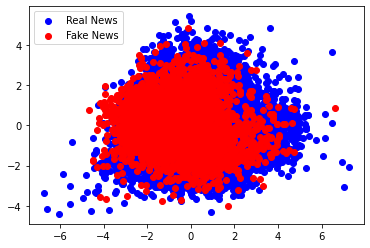

In [28]:
from sklearn.decomposition import PCA as sklearnPCA
pca = sklearnPCA(n_components=2) #2-dimensional PCA
transformed = pd.DataFrame(pca.fit_transform(embedded_df))
y=df['fake']

plt.scatter(transformed[y==0][0], transformed[y==0][1], label='Real News', c='blue')
plt.scatter(transformed[y==1][0], transformed[y==1][1], label='Fake News', c='red')

plt.legend()
plt.show()


## The motivation behind this plot was to check if there is any clear clustering. But as expected for a data of this kind, there is no such demarcation.